In [ ]:
#%%

import os
# %load_ext autoreload
# %autoreload 2

## Do not preallocate GPU memory
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = '\"platform\"'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'

from nodax import *
# jax.config.update("jax_debug_nans", True)

## Execute jax on CPU
# jax.config.update("jax_platform_name", "cpu")


############# Neural Context Flow #############

Jax version: 0.4.28
Available devices: [cuda(id=0)]


In [ ]:
#%%

seed = 2026
# seed = int(np.random.randint(0, 10000))

## Neural Context Flow hyperparameters ##
context_pool_size = 4               ## Number of neighboring contexts j to use for a flow in env e
context_size = 2
print_error_every = 100
# integrator = diffrax.Dopri5
integrator = RK4
ivp_args = {"dt_init":1e-4, "rtol":1e-3, "atol":1e-6, "max_steps":40000, "subdivisions":5}
## subdivision is used for non-adaptive integrators like RK4. It's the number of extra steps to take between each evaluation time point
# run_folder = "./runs/09032024-155347/"      ## Run folder to use when not training
run_folder = "./"

## Training hyperparameters ##
train = False
save_trainer = True
finetune = False

init_lr = 3e-4
sched_factor = 1.0

nb_epochs = 20000
# nb_outer_steps_max = 1
# nb_inner_steps_max = 30
# proximal_beta = 1e2 ## See beta in https://proceedings.mlr.press/v97/li19n.html
# inner_tol_node = 1e-16
# inner_tol_ctx = 1e-16
# early_stopping_patience = nb_outer_steps_max//1       ## Number of outer steps to wait before early stopping


## Adaptation hyperparameters ##
adapt_test = True
adapt_restore = False

init_lr_adapt = 5e-3
sched_factor_adapt = 0.5
nb_epochs_adapt = 1500

In [ ]:
#%%

if train == True:

    # check that 'tmp' folder exists. If not, create it
    if not os.path.exists('./'):
        os.mkdir('./')

    # Make a new folder inside 'tmp' whose name is the current time
    run_folder = './'
    # run_folder = './runs/'+time.strftime("%d%m%Y-%H%M%S")+'/'
    os.mkdir(run_folder)

    # Save the run and dataset scripts in that folder
    script_name = os.path.basename(__file__)
    os.system(f"cp {script_name} {run_folder}")
    os.system(f"cp dataset.py {run_folder}")

    # Save the nodax module files as well
    os.system(f"cp -r ../../nodax {run_folder}")
    print("Completed copied scripts ")


else:
    # run_folder = "./runs/22022024-112457/"  ## Needed for loading the model and finetuning TODO: opti
    print("No training. Loading data and results from:", run_folder)

## Create a folder for the adaptation results
adapt_folder = run_folder+"adapt/"
if not os.path.exists(adapt_folder):
    os.mkdir(adapt_folder)

No training. Loading data and results from: ./


In [ ]:
#%%

if train == True:
    # Run the dataset script to generate the data
    os.system(f'python dataset.py --split=train --savepath="{run_folder}" --seed="{seed}"')
    os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}"')

In [ ]:
#%%

## Define dataloader for training and validation
train_dataloader = DataLoader(run_folder+"train_data.npz", batch_size=-1, shuffle=True, key=seed)

nb_envs = train_dataloader.nb_envs
nb_trajs_per_env = train_dataloader.nb_trajs_per_env
nb_steps_per_traj = train_dataloader.nb_steps_per_traj
data_size = train_dataloader.data_size

val_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)

In [ ]:
#%%

## Define model and loss function for the learner

class Swish(eqx.Module):
    beta: jnp.ndarray
    def __init__(self, key=None):
        self.beta = jax.random.uniform(key, shape=(1,), minval=0.01, maxval=1.0)
    def __call__(self, x):
        return x * jax.nn.sigmoid(self.beta * x)

class Augmentation(eqx.Module):
    layers_shared: list
    activations: list

    def __init__(self, data_size, int_size, context_size, key=None):
        keys = generate_new_keys(key, num=12)
        self.activations = [Swish(key=key_i) for key_i in keys[:7]]

        self.layers_shared = [eqx.nn.Linear(data_size+context_size, int_size, key=keys[6]), self.activations[4], 
                              eqx.nn.Linear(int_size, int_size, key=keys[7]), self.activations[5], 
                              eqx.nn.Linear(int_size, int_size, key=keys[8]), self.activations[6], 
                              eqx.nn.Linear(int_size, data_size, key=keys[9])]

    def __call__(self, t, y, ctx):

        y = jnp.concatenate([y, ctx], axis=0)
        for layer in self.layers_shared:
            y = layer(y)

        return y



class ContextFlowVectorField(eqx.Module):
    physics: eqx.Module
    augmentation: eqx.Module

    def __init__(self, augmentation, physics=None):
        self.augmentation = augmentation
        self.physics = physics

    def __call__(self, t, x, ctxs):
        if self.physics is None:
            vf = lambda xi_: self.augmentation(t, x, xi_)
        else:
            vf = lambda xi_: self.physics(t, x, xi_) + self.augmentation(t, x, xi_)

        gradvf = lambda xi_, xi: eqx.filter_jvp(vf, (xi_,), (xi-xi_,))[1]

        ctx, ctx_ = ctxs
        return vf(ctx_) + gradvf(ctx_, ctx)


# class ContextFlowVectorField(eqx.Module):
#     physics: eqx.Module
#     augmentation: eqx.Module

#     def __init__(self, augmentation, physics=None):
#         self.augmentation = augmentation
#         self.physics = physics

#     def __call__(self, t, x, ctxs):
#         ctx, ctx_ = ctxs

#         if self.physics is None:
#             vf = lambda xi: self.augmentation(t, x, xi)
#         else:
#             vf = lambda xi: self.physics(t, x, xi) + self.augmentation(t, x, xi)

#         gradvf = lambda xi_: eqx.filter_jvp(vf, (xi_,), (ctx-xi_,))[1]
#         scd_order_term = eqx.filter_jvp(gradvf, (ctx_,), (ctx-ctx_,))[1]

#         return vf(ctx_) + 1.5*gradvf(ctx_) + 0.5*scd_order_term


augmentation = Augmentation(data_size=2, int_size=64, context_size=context_size, key=seed)

# physics = Physics(key=seed)
physics = None

vectorfield = ContextFlowVectorField(augmentation, physics=physics)

print("\n\nTotal number of parameters in the model:", sum(x.size for x in jax.tree_util.tree_leaves(eqx.filter(vectorfield,eqx.is_array)) if x is not None), "\n\n")

contexts = ContextParams(nb_envs, context_size, key=None)

## Define a custom loss function here
def loss_fn_ctx(model, trajs, t_eval, ctx, all_ctx_s, key):

    # # ind = jax.random.randint(key, shape=(context_pool_size,), minval=0, maxval=all_ctx_s.shape[0])
    # ind = jax.random.permutation(key, all_ctx_s.shape[0])[:context_pool_size]
    # ctx_s = all_ctx_s[ind, :]

    ## Select the two closes vectors in all_ctx_s to ctx
    # dists = jnp.linalg.norm(all_ctx_s - ctx, axis=1)
    dists = jnp.mean(jnp.abs(all_ctx_s - ctx), axis=1)
    ind = jnp.argsort(dists)[0:context_pool_size]        ## ctx itself, and the closest context
    # ind = jnp.argsort(dists)[1:2]        ## ctx itself, and the closest context         ## TODO only use the closest for minimal compute
    ctx_s = all_ctx_s[ind, :]

    # ## Select the smallest-first vectors in all_ctx_s
    # dists = jnp.mean(jnp.abs(all_ctx_s), axis=1)
    # ind = jnp.argsort(dists)[0:context_pool_size]
    # ctx_s = all_ctx_s[ind, :]

    trajs_hat, nb_steps = jax.vmap(model, in_axes=(None, None, None, 0))(trajs[:, 0, :], t_eval, ctx, ctx_s)
    new_trajs = jnp.broadcast_to(trajs, trajs_hat.shape)

    term1 = jnp.mean((new_trajs-trajs_hat)**2)  ## reconstruction
    # term2 = jnp.mean(ctx**2)             ## regularisation
    term2 = jnp.mean(jnp.abs(ctx))             ## regularisation
    # term2 = params_norm_squared(ctx)
    # term3 = params_norm_squared(model)

    loss_val = term1 + 1e-3*term2
    # loss_val = term1 + 1e-3*term2 + 1e-3*term3
    # loss_val = jnp.nan_to_num(term1, nan=0.0, posinf=0.0, neginf=0.0)
    # loss_val = term1

    return loss_val, (jnp.sum(nb_steps)/ctx_s.shape[0], term1, term2)




learner = Learner(vectorfield, contexts, loss_fn_ctx, integrator, ivp_args, key=seed)



Total number of parameters in the model: 8780 




In [ ]:
#%%

## Define optimiser and traine the model

nb_total_epochs = nb_epochs
sched_node = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:sched_factor, 2*nb_total_epochs//3:sched_factor})

sched_ctx = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:sched_factor, 2*nb_total_epochs//3:sched_factor})

opt_node = optax.adam(sched_node)
opt_ctx = optax.adam(sched_ctx)

trainer = Trainer(train_dataloader, learner, (opt_node, opt_ctx), key=seed)

In [ ]:
#%%

trainer_save_path = run_folder if save_trainer == True else False
if train == True:
    # for i, prop in enumerate(np.linspace(0.25, 1.0, 3)):
    for i, prop in enumerate(np.linspace(1.0, 1.0, 1)):
        # trainer.dataloader.int_cutoff = int(prop*nb_steps_per_traj)
        trainer.train(nb_epochs=nb_epochs*(2**0), print_error_every=print_error_every*(2**0), update_context_every=1, save_path=trainer_save_path, key=seed, val_dataloader=val_dataloader, int_prop=prop)
        # trainer.train_proximal(nb_outer_steps_max=nb_outer_steps_max, 
        #                        nb_inner_steps_max=nb_inner_steps_max, 
        #                        proximal_reg=proximal_beta, 
        #                        inner_tol_node=inner_tol_node, 
        #                        inner_tol_ctx=inner_tol_ctx,
        #                        print_error_every=print_error_every*(2**0), 
        #                        save_path=trainer_save_path, 
        #                        val_dataloader=val_dataloader, 
        #                        patience=early_stopping_patience,
        #                        int_prop=prop,
        #                        key=seed)

else:
    # print("\nNo training, attempting to load model and results from "+ run_folder +" folder ...\n")

    restore_folder = run_folder
    # restore_folder = "./runs/27012024-155719/finetune_193625/"
    trainer.restore_trainer(path=restore_folder)


No training, loading model and results from ./ folder ...



In [ ]:
#%%

if finetune:
    # ## Finetune a trained model

    finetunedir = run_folder+"finetune_"+trainer.dataloader.data_id+"/"
    if not os.path.exists(finetunedir):
        os.mkdir(finetunedir)
    print("No training. Loading anctx_sd finetuning into:", finetunedir)

    trainer.dataloader.int_cutoff = nb_steps_per_traj

    opt_node = optax.adabelief(1e-7)
    opt_ctx = optax.adabelief(1e-7)
    trainer.opt_node, trainer.opt_ctx = opt_node, opt_ctx

    # trainer.opt_node_state = trainer.opt_node.init(eqx.filter(trainer.learner.neuralode, eqx.is_array))
    # trainer.opt_ctx_state = trainer.opt_ctx.init(trainer.learner.contexts)

    trainer.train(nb_epochs=24000, print_error_every=1000, update_context_every=1, save_path=finetunedir, key=seed)

==  Begining in-domain testing ... ==
    Number of training environments: 9
    Final length of the training trajectories: 20
    Length of the testing trajectories: 20
Test Score (In-Domain): 0.000100066565

==  Begining in-domain visualisation ... ==
    Environment id: 5
    Trajectory id: 17
    Visualized dimensions: (0, 1)
    Final length of the training trajectories: 20
    Length of the testing trajectories: 20
Testing finished. Figure saved in: ./results_in_domain.png


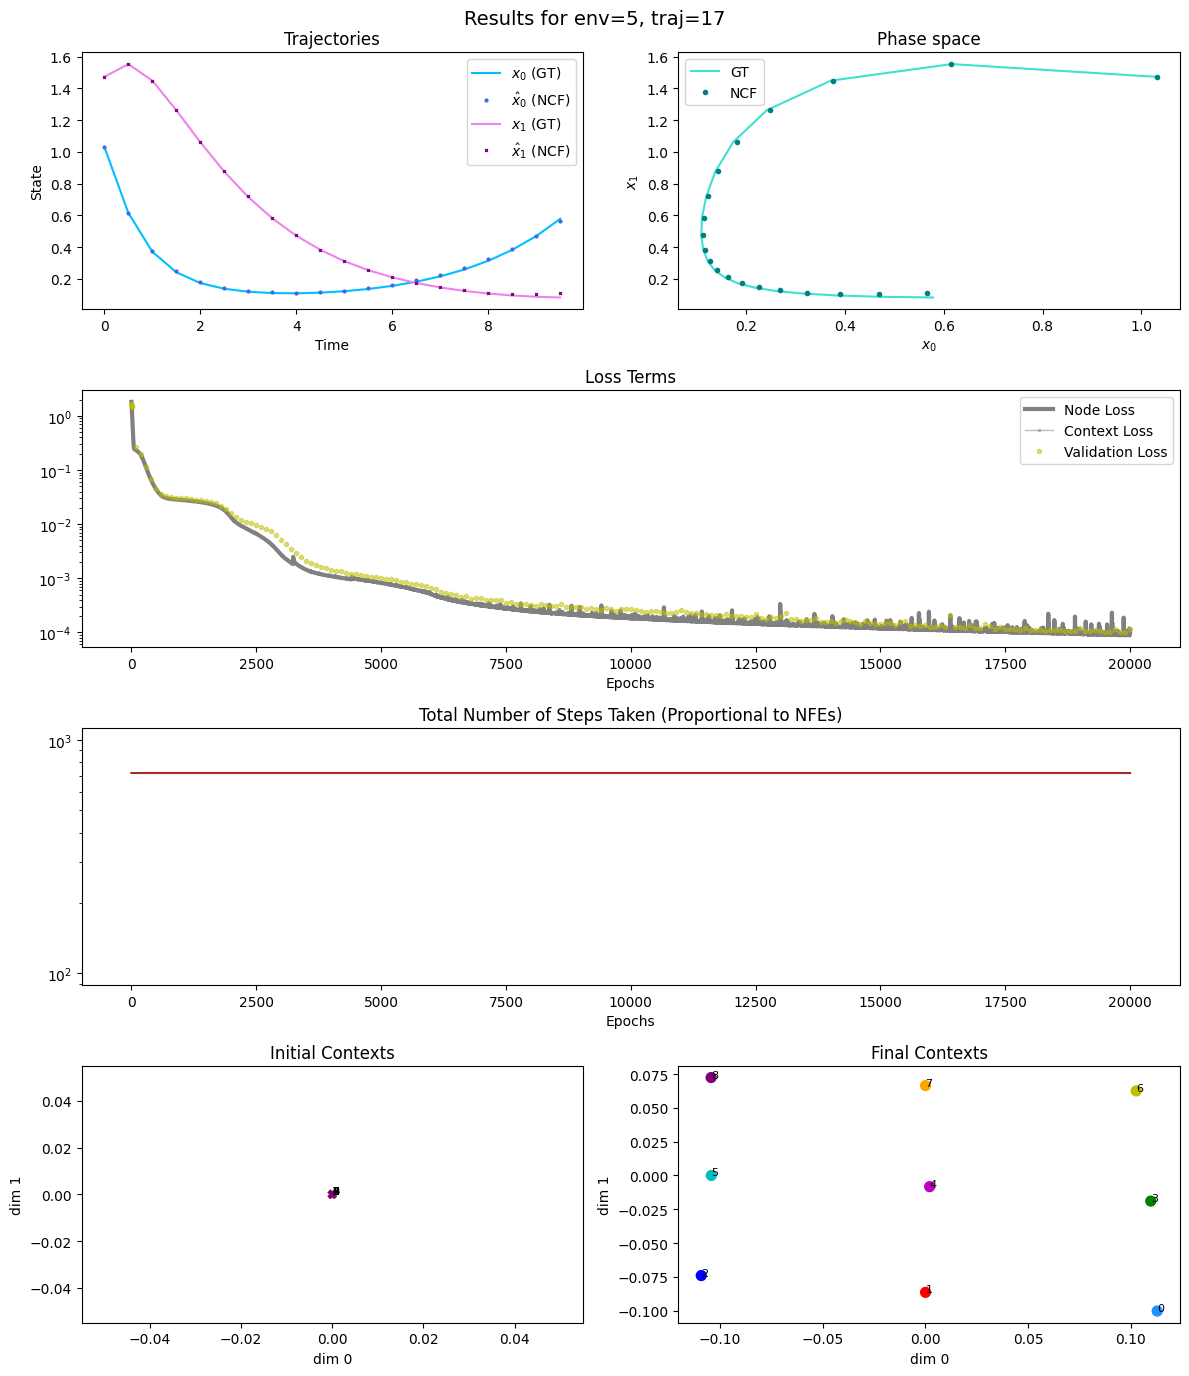

In [ ]:
#%%

## Test and visualise the results on a test dataloader

test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)
visualtester = VisualTester(trainer)
# ans = visualtester.trainer.nb_steps_node
# print(ans.shape)

ind_crit = visualtester.test(test_dataloader, int_cutoff=1.0)

if finetune:
    savefigdir = finetunedir+"results_in_domain.png"
else:
    savefigdir = run_folder+"results_in_domain.png"
visualtester.visualize(test_dataloader, int_cutoff=1.0, save_path=savefigdir);

In [ ]:
#%%

## Give the dataloader an id to help with restoration later on

if adapt_test and not adapt_restore:
    os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}"');
    os.system(f'python dataset.py --split=adapt_test --savepath="{adapt_folder}" --seed="{seed*3}"');

# if adapt_test:
#     raw_dat = np.load(adapt_folder+"adapt_data.npz")
#     adapt_dataset, adapt_t_eval = jnp.asarray(raw_dat['X']), jnp.asarray(raw_dat['t'])

#     total_ood_crit = 0
#     nb_envs_adapt = adapt_dataset.shape[0]
#     # contexts = []

#     for a in range(nb_envs_adapt):
#         adapt_dataloader = DataLoader(adapt_dataset[a:a+1,...], t_eval=adapt_t_eval, adaptation=True, data_id="170846_"+str(a), key=seed)

#         sched_ctx_new = optax.piecewise_constant_schedule(init_value=init_lr_adapt,
#                                 boundaries_and_scales={nb_total_epochs//3:sched_factor_adapt, 2*nb_total_epochs//3:sched_factor_adapt})
#         opt_adapt = optax.adabelief(sched_ctx_new)

#         if adapt_restore == False:
#             trainer.adapt(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
#         else:
#             print("Save_id for restoring trained adapation model:", adapt_dataloader.data_id)
#             trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

#         ood_crit, _ = visualtester.test(adapt_dataloader, int_cutoff=1.0)
#         total_ood_crit += ood_crit
#         # contexts = np.append(contexts, trainer.learner.contexts.params)

#     ood_crit = total_ood_crit/nb_envs_adapt

#     visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood.png");

#     # ## Set the context to the stack of the contexts
#     # trainer.learner.contexts = eqx.tree_at(lambda c: c.params, trainer.learner.contexts, jnp.stack(contexts))


############# Neural Context Flow #############

Jax version: 0.4.28
Available devices: [cuda(id=0)]
Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt
 Savepath: ./adapt/
 Seed: 6078


############# Neural Context Flow #############

Jax version: 0.4.28
Available devices: [cuda(id=0)]
Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt_test
 Savepath: ./adapt/
 Seed: 6078





=== Beginning sequential adaptation ... ===
    Number of examples in a batch: 1
    Number of train steps per epoch: 1
    Number of training epochs: 1500
    Total number of training steps: 1500

Adapting to environment 0 ...

Compiling function "train_step" for context ...
Shapes of elements in a batch: (1, 1, 20, 2) (20,)
    Epoch:     0     LossContext: 0.02397467
    Epoch:     1     LossContext: 0.02067801
    Epoch:     2     LossContext: 0.01730563
    Epoch:     3     LossContext: 0.01391805
    Epoch:   100     LossContext: 0.00007607
    Epoch:   200     LossContext: 0.00007556
    Epoch:   300     LossContext: 0.00007556
    Epoch:   400     LossContext: 0.00007556
    Epoch:   500     LossContext: 0.00007556
    Epoch:   600     LossContext: 0.00007556
    Epoch:   700     LossContext: 0.00007556
    Epoch:   800     LossContext: 0.00007556
    Epoch:   900     LossContext: 0.00007556
    Epoch:  1000     LossContext: 0.00007556
    Epoch:  1100     LossContext: 0.0000

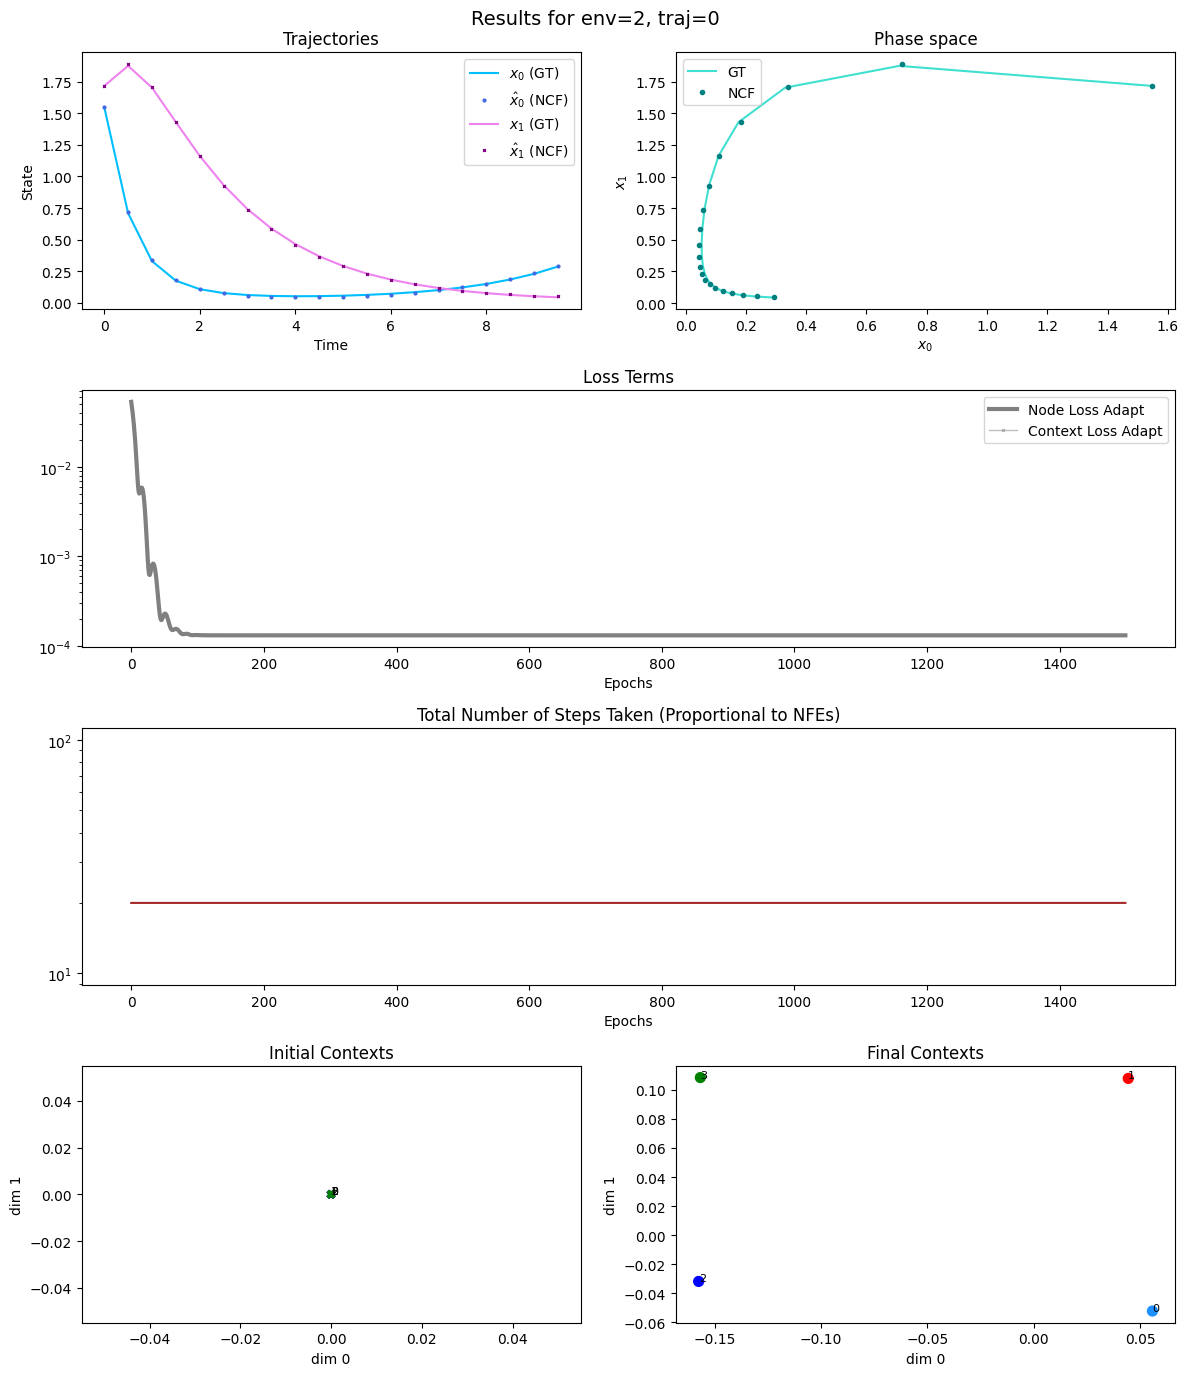

In [ ]:
#%%

if adapt_test:

    adapt_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, data_id="170846", key=seed)
    adapt_dataloader_test = DataLoader(adapt_folder+"adapt_data_test.npz", adaptation=True, data_id="1708460", key=seed)
    # print("shape of adapt_dataloader", adapt_dataloader.dataset.shape)

    sched_ctx_new = optax.piecewise_constant_schedule(init_value=init_lr_adapt,
                            boundaries_and_scales={nb_total_epochs//3:sched_factor_adapt, 2*nb_total_epochs//3:sched_factor_adapt})
    opt_adapt = optax.adabelief(sched_ctx_new)

    if adapt_restore == False:
        trainer.adapt_sequential(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
    else:
        print("Save_id for restoring trained adapation model:", adapt_dataloader.data_id)
        trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

    ood_crit, _ = visualtester.test(adapt_dataloader_test, int_cutoff=1.0)
    # contexts = np.append(contexts, trainer.learner.contexts.params)

    visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood.png");

In [ ]:
#%%

# # eqx.tree_deserialise_leaves(run_folder+"contexts.eqx", learner.contexts)
# print("Kernel layer 1\n", trainer.learner.neuralode.vectorfield.physics.layers[0].weight)
# print("Kernel layer 2\n", trainer.learner.neuralode.vectorfield.physics.layers[1].weight)

In [ ]:
#%%

#### Generate data for analysis


# ## We want to store 3 values in a CSV file: "seed", "ind_crit", and "ood_crit", into the test_scores.csv file


# print("\nFull evaluation of the model on many random seeds\n", flush=True)

# # First, create the test_scores.csv file
# if not os.path.exists(run_folder+'analysis'):
#     os.mkdir(run_folder+'analysis')

# csv_file = run_folder+'analysis/test_scores.csv'
# if os.path.exists(csv_file):
#     os.system(f"rm {csv_file}")

# os.system(f"touch {csv_file}")

# with open(csv_file, 'r') as f:
#     lines = f.readlines()
#     if len(lines) == 0:
#         with open(csv_file, 'w') as f:
#             f.write("seed,ind_crit,ood_crit\n")


# ## Get results on test and adaptation datasets, then append them to the csv

# np.random.seed(seed*2)
# seeds = np.random.randint(0, 10000, 5)
# for seed in seeds:
# # for seed in range(8000, 6*10**3, 10):
#     os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}" --verbose=0')
#     os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}" --verbose=0')

#     test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False, batch_size=-1, data_id="082026")
#     adapt_test_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, batch_size=-1, key=seed, data_id="082026")

#     ind_crit, _ = visualtester.test(test_dataloader, int_cutoff=1.0, verbose=False)
#     ood_crit, _ = visualtester.test(adapt_test_dataloader, int_cutoff=1.0, verbose=False)

#     with open(csv_file, 'a') as f:
#         f.write(f"{seed},{ind_crit},{ood_crit}\n")


# ## Print the mean and stds of the scores
# import pandas as pd
# pd.set_option('display.float_format', '{:.2e}'.format)
# test_scores = pd.read_csv(csv_file).describe()

# print("\n\nMean and std of the scores across various datasets\n", flush=True)
# print(test_scores.iloc[:3])

In [ ]:
#%%

## If the nohup.log file exists, copy it to the run folder
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    if os.path.exists("nohup.log"):
        if finetune == True:
            os.system(f"cp nohup.log {finetunedir}")
            ## Open the results_in_domain in the terminal
            # os.system(f"open {finetunedir}results_in_domain.png")
        # elif adapt_test==True: ## Adaptation
        #     os.system(f"cp nohup.log {adapt_folder}")
        else:
            os.system(f"cp nohup.log {run_folder}")
            # os.system(f"open {run_folder}results_in_domain.png")